# **Huấn luyện**

In [2]:
!pip install torch_geometric


[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


## **Import dữ liệu**

In [3]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from itertools import combinations

import torch
import torch.nn.functional as F
import numpy as np
from sklearn.metrics import accuracy_score, f1_score
import matplotlib.pyplot as plt
import pandas as pd
from torch_geometric.nn import GATConv, LayerNorm
from imblearn.over_sampling import SMOTE
from torch_geometric.data import Data
from sklearn.model_selection import train_test_split

In [4]:
# Đọc dataset
file_path = r'D:\Năm 3 - HK2\Mạng xã hội\traffic-accident-analysis\data\encoded_dataset_cleaned.csv'
df = pd.read_csv(file_path)

df = df.sample(2000) # Lấy ngẫu nhiên 2000 dòng dữ liệu

print(df.columns)
print(df['damage'].value_counts())
print(df['damage'].unique())

Index(['traffic_control_device', 'weather_condition', 'lighting_condition',
       'first_crash_type', 'trafficway_type', 'alignment',
       'roadway_surface_cond', 'road_defect', 'crash_type',
       'intersection_related_i', 'damage', 'prim_contributory_cause',
       'num_units', 'most_severe_injury', 'injuries_total', 'injuries_fatal',
       'injuries_incapacitating', 'injuries_non_incapacitating',
       'injuries_reported_not_evident', 'injuries_no_indication', 'crash_hour',
       'crash_day_of_week', 'crash_month'],
      dtype='object')
damage
2    1410
1     372
0     218
Name: count, dtype: int64
[2 1 0]


In [5]:
# Khởi tạo đồ thị
G = nx.Graph()

# Thêm nút cho mỗi vụ tai nạn (dựa trên index)
for index, row in df.iterrows():
    G.add_node(index,
               traffic_control_device=row['traffic_control_device'],
               weather_condition=row['weather_condition'],
               lighting_condition=row['lighting_condition'],
               first_crash_type=row['first_crash_type'],
               trafficway_type=row['trafficway_type'],
               alignment=row['alignment'],
               roadway_surface_cond=row['roadway_surface_cond'],
               road_defect=row['road_defect'],
               crash_type=row['crash_type'],
               intersection_related_i=row['intersection_related_i'],
               damage=row['damage'],
               prim_contributory_cause=row['prim_contributory_cause'],
               num_units=row['num_units'],
               most_severe_injury=row['most_severe_injury'],
               injuries_total=row['injuries_total'],
               injuries_fatal=row['injuries_fatal'],
               injuries_incapacitating=row['injuries_incapacitating'],
               injuries_non_incapacitating=row['injuries_non_incapacitating'],
               injuries_reported_not_evident=row['injuries_reported_not_evident'],
               injuries_no_indication=row['injuries_no_indication'],
               crash_hour=row['crash_hour'],
               crash_day_of_week=row['crash_day_of_week'],
               crash_month=row['crash_month'])

# Hàm kiểm tra điều kiện kết nối giữa hai vụ tai nạn
def is_similar(accident1, accident2):
    # Các điều kiện tương tự dựa trên các đặc trưng quan trọng
    time_diff = abs(accident1['crash_hour'] - accident2['crash_hour']) <= 1
    same_month = accident1['crash_month'] == accident2['crash_month']
    same_day_of_week = accident1['crash_day_of_week'] == accident2['crash_day_of_week']
    same_trafficway = accident1['trafficway_type'] == accident2['trafficway_type']
    same_crash_type = accident1['first_crash_type'] == accident2['first_crash_type']
    same_injury_no_indication = accident1['injuries_no_indication'] == accident2['injuries_no_indication']

    # Kết nối nếu ít nhất một điều kiện tương tự
    return (time_diff or same_month or same_day_of_week or same_trafficway or
            same_crash_type or same_injury_no_indication)

# Thêm các cạnh dựa trên tính tương đồng
for u, v in combinations(G.nodes(data=True), 2):
    if is_similar(u[1], v[1]):
        G.add_edge(u[0], v[0])

print("Đồ thị G đã được tạo với", G.number_of_nodes(), "nút và", G.number_of_edges(), "cạnh.")

Đồ thị G đã được tạo với 2000 nút và 1459095 cạnh.


## **Huấn luyện và trực quan hóa mô hình GAT**

In [6]:
# Định nghĩa Focal Loss
class FocalLoss(torch.nn.Module):
    def __init__(self, alpha=None, gamma=2.0):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, logits, targets):
        ce_loss = F.cross_entropy(logits, targets, weight=self.alpha, reduction="none")
        pt = torch.exp(-ce_loss)
        focal_loss = (1 - pt) ** self.gamma * ce_loss
        return focal_loss.mean()

# Chuyển đổi từ NetworkX sang PyG Data (giả định G đã được định nghĩa)
def networkx_to_pyg(G, label_attr="damage"):
    node_mapping = {node: i for i, node in enumerate(G.nodes())}
    edge_index = torch.tensor([[node_mapping[u], node_mapping[v]] for u, v in G.edges()], dtype=torch.long).t().contiguous()

    features = []
    labels = []
    for node, data in G.nodes(data=True):
        node_features = [data[attr] for attr in data if attr != label_attr]
        features.append(node_features)
        labels.append(data[label_attr])

    X = torch.tensor(features, dtype=torch.float)
    y = torch.tensor(labels, dtype=torch.long)
    return Data(x=X, edge_index=edge_index, y=y)

In [7]:
# Mô hình GAT
class GAT(torch.nn.Module):
    def __init__(self, in_features, hidden_dim, out_features, heads=8):
        super(GAT, self).__init__()
        self.gat1 = GATConv(in_features, hidden_dim, heads=heads, dropout=0.2)
        self.ln1 = LayerNorm(hidden_dim * heads)

        self.gat2 = GATConv(hidden_dim * heads, hidden_dim, heads=4, dropout=0.2)
        self.ln2 = LayerNorm(hidden_dim * 4)

        self.gat3 = GATConv(hidden_dim * 4, out_features, heads=1, concat=False, dropout=0.2)
        self.dropout = torch.nn.Dropout(0.1)

    def forward(self, x, edge_index):
        x = self.gat1(x, edge_index)
        x = self.ln1(x)
        x = F.elu(x)
        x = self.dropout(x)

        x = self.gat2(x, edge_index)
        x = self.ln2(x)
        x = F.elu(x)
        x = self.dropout(x)

        x = self.gat3(x, edge_index)
        return F.log_softmax(x, dim=1)

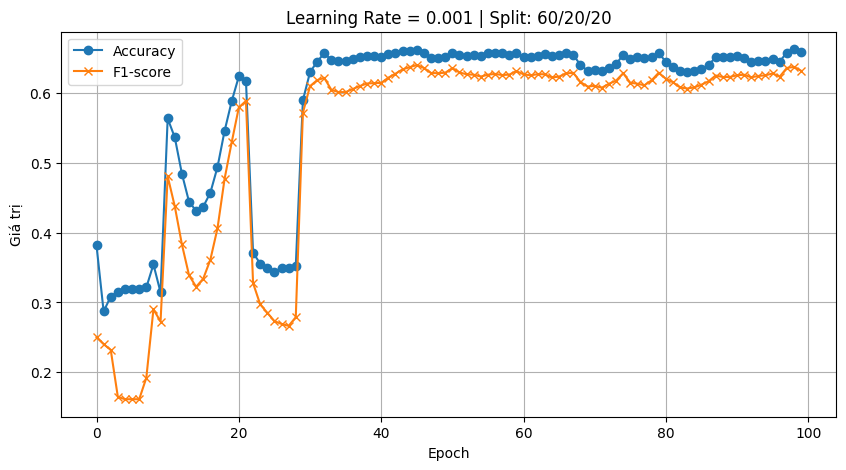

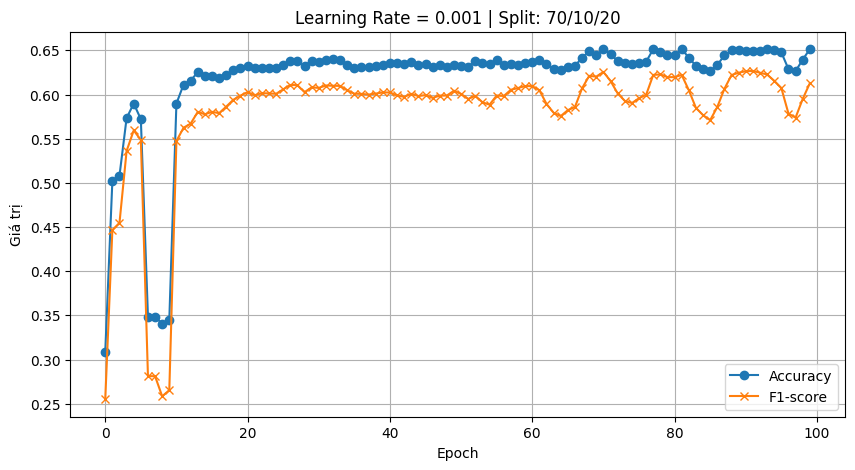

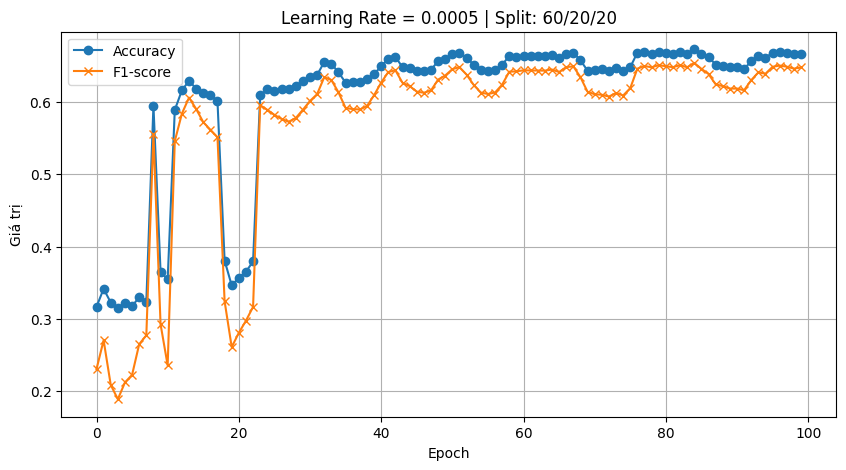

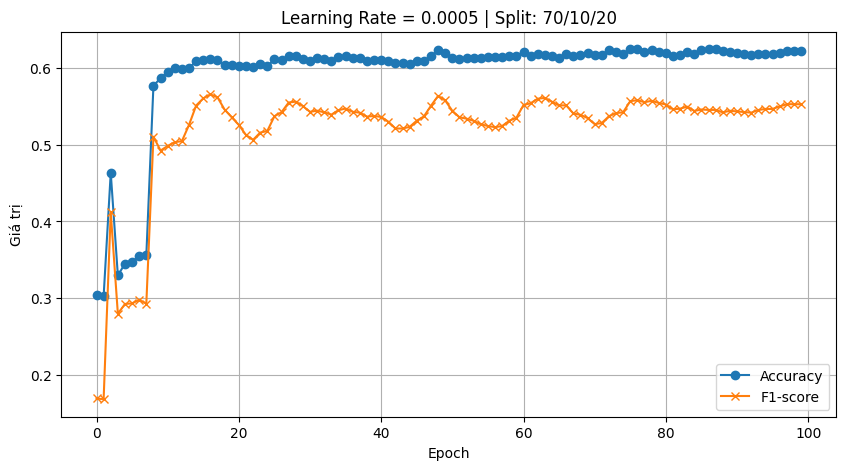

In [8]:
# Test nhiều trường hợp với lr và split khác nhau
lr_list = [0.001, 0.0005]
split_ratios = [(0.6, 0.2, 0.2), (0.7, 0.1, 0.2)]

results = []

for lr in lr_list:
    for train_ratio, val_ratio, test_ratio in split_ratios:

        # Tạo bản sao dữ liệu và xử lý SMOTE
        data = networkx_to_pyg(G)
        X_resampled, y_resampled = SMOTE().fit_resample(data.x.numpy(), data.y.numpy())
        data.x = torch.tensor(X_resampled, dtype=torch.float)
        data.y = torch.tensor(y_resampled, dtype=torch.long)

        # Chia dữ liệu
        num_nodes = data.num_nodes
        idx = list(range(num_nodes))
        train_idx, temp_idx = train_test_split(idx, train_size=train_ratio, random_state=42)
        val_size = val_ratio / (val_ratio + test_ratio)
        val_idx, test_idx = train_test_split(temp_idx, train_size=val_size, random_state=42)

        data.train_mask = torch.tensor(train_idx, dtype=torch.long)
        data.val_mask = torch.tensor(val_idx, dtype=torch.long)
        data.test_mask = torch.tensor(test_idx, dtype=torch.long)

        # Tính trọng số class
        unique, counts = np.unique(data.y.numpy(), return_counts=True)
        class_weights = torch.tensor(1.0 / counts, dtype=torch.float)
        class_weights /= class_weights.sum()
        loss_fn = FocalLoss(alpha=class_weights, gamma=2.0)

        # Khởi tạo và huấn luyện mô hình
        model = GAT(in_features=data.x.shape[1], hidden_dim=16, out_features=len(data.y.unique()))
        optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=5e-4)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10)

        accuracies, f1_scores, epochs = [], [], []
        for epoch in range(100):
            model.train()
            optimizer.zero_grad()
            out = model(data.x, data.edge_index)
            loss = loss_fn(out[data.train_mask], data.y[data.train_mask])
            loss.backward()
            optimizer.step()
            scheduler.step(loss)

            model.eval()
            with torch.no_grad():
                logits = model(data.x, data.edge_index)
                pred = logits.argmax(dim=1)

                y_true = data.y[data.test_mask].cpu().numpy()
                y_pred = pred[data.test_mask].cpu().numpy()
                acc = accuracy_score(y_true, y_pred)
                f1 = f1_score(y_true, y_pred, average='macro')

                epochs.append(epoch)
                accuracies.append(acc)
                f1_scores.append(f1)

        # Lưu kết quả
        results.append({
            'lr': lr,
            'split': f"{int(train_ratio*100)}/{int(val_ratio*100)}/{int(test_ratio*100)}",
            'epochs': epochs,
            'acc': accuracies,
            'f1': f1_scores
        })

        # Vẽ biểu đồ
        plt.figure(figsize=(10, 5))
        plt.plot(epochs, accuracies, label='Accuracy', marker='o')
        plt.plot(epochs, f1_scores, label='F1-score', marker='x')
        plt.xlabel('Epoch')
        plt.ylabel('Giá trị')
        plt.title(f"Learning Rate = {lr} | Split: {int(train_ratio*100)}/{int(val_ratio*100)}/{int(test_ratio*100)}")
        plt.legend()
        plt.grid(True)
        plt.show()

In [16]:
torch.save(model.state_dict(), 'gat_model.pth')


In [10]:
# Tạo bảng tổng hợp kết quả cuối cùng
summary = []
for r in results:
    summary.append({
        'Learning Rate': r['lr'],
        'Split': r['split'],
        'Accuracy Cuối': round(r['acc'][-1], 4),
        'F1-score Cuối': round(r['f1'][-1], 4)
    })

# In bảng
df = pd.DataFrame(summary)
print(df.to_markdown(index=False))

|   Learning Rate | Split    |   Accuracy Cuối |   F1-score Cuối |
|----------------:|:---------|----------------:|----------------:|
|          0.001  | 60/20/20 |          0.6596 |          0.6323 |
|          0.001  | 70/10/20 |          0.6513 |          0.6127 |
|          0.0005 | 60/20/20 |          0.6667 |          0.6473 |
|          0.0005 | 70/10/20 |          0.6217 |          0.5526 |


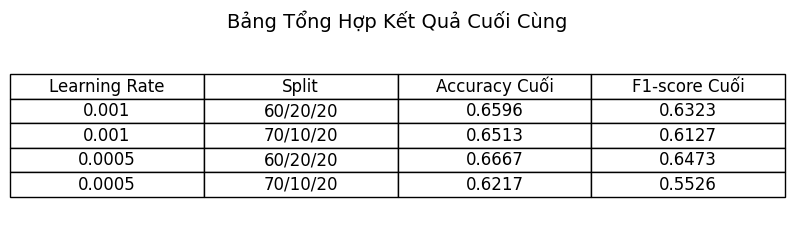

In [11]:
# Vẽ bảng kết quả
fig, ax = plt.subplots(figsize=(8, 2.5))
ax.axis('off')  # Ẩn trục

table = ax.table(
    cellText=df.values,
    colLabels=df.columns,
    cellLoc='center',
    loc='center'
)

table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1.2, 1.5)

plt.title("Bảng Tổng Hợp Kết Quả Cuối Cùng", fontsize=14, pad=10)
plt.tight_layout()
plt.show()
